# Machine Learning on ATLAS Open Data

In [1]:
import sys
import pickle
import json
import numpy as np
from numpy import random
import pandas as pd
import os.path
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import uproot
import vector
import awkward

In [3]:
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import math
# SKL
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
import time

In [5]:
import tensorflow as tf
from tensorflow.keras import optimizers
#import keras_tuner as kt
from Utilities import *

In [6]:
import glob

In [7]:
from keras.models import Sequential, load_model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [8]:
from tensorflow.python.client import device_lib 

In [9]:
import xgboost as XGB

In [10]:
import sys
import logging
logging.basicConfig(
                    format="%(message)s",
                    level=logging.ERROR,
                    stream=sys.stdout)
logging.getLogger('matplotlib.font_manager').disabled = True

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Ok, let's start by reading in some data after we've loaded all of the modules above. The dataframe can in principle be any data frame with a set of features, but this examples will use a data frame created from the ATLAS Open data using the example in the NtupToDF notebook which you can find in [zpath github](https://github.uio.no/zpath/software/tree/master/Notebooks/ATLASOpenData/13TeV) (and which should also be accessible from the FYS5555 interactive session in Galaxy). But for this tutorial you would not need to bother about this since we already created a data frame which is directly accessible from the local disk.

In [12]:
df = pd.read_hdf("/storage/shared/data/2lep_df_forML.hdf5")

The signal simulations are put in a separate hdf5 file, but put it into (concatenate) the same data frame

In [13]:
df = pd.concat([df,pd.read_hdf("/storage/shared/data/2lep_df_forML_signal.hdf5")])

Have a look at the first five events (rows) data frame (it contains 21 variables/features). Among them the background/signal category and weights for scaling the simulation to data.

In [14]:
df.head()

,lep_pt1,lep_eta1,lep_phi1,lep_E1,lep_pt2,lep_eta2,lep_phi2,lep_E2,met,mll,...,njet60,nbjet60,nbjet70,nbjet77,nbjet80,isSF,isOS,weight,category,isSignal
0,124.174242,0.874867,1.808438,174.804609,36.407164,-0.088034,2.809092,36.548332,26.631432,93.204437,...,1,2,1,1,1,1,1,0.003813,Diboson,0
1,81.009211,-0.172663,2.475907,82.219758,49.662348,0.419312,1.085146,54.092566,29.575090,89.760332,...,2,2,2,2,2,1,1,0.006575,Diboson,0
2,71.252680,-0.190694,2.687513,72.552219,34.968070,-1.183697,-2.000721,62.463102,24.493008,88.141915,...,1,3,3,3,3,1,1,-0.003541,Diboson,0
3,52.469828,0.626280,-3.089676,63.100617,42.395828,0.286550,-0.852670,44.148352,12.226987,86.358315,...,0,2,2,2,2,1,1,0.003503,Diboson,0
4,61.642246,-0.359743,-0.503622,65.674258,31.970502,-1.249790,1.979540,60.363176,32.936660,93.413226,...,1,1,1,1,1,1,1,0.006379,Diboson,0


... and here are all the features

In [15]:
df.columns

Index(['lep_pt1', 'lep_eta1', 'lep_phi1', 'lep_E1', 'lep_pt2', 'lep_eta2',
       'lep_phi2', 'lep_E2', 'met', 'mll', 'njet20', 'njet60', 'nbjet60',
       'nbjet70', 'nbjet77', 'nbjet80', 'isSF', 'isOS', 'weight', 'category',
       'isSignal'],
      dtype='object')

And this is how many features and events we have

In [16]:
print("Number of events = %i"%df.shape[0])
print("Number of features = %i"%df.shape[1])

Number of events = 109683372
Number of features = 21


Load some home made tools, mainly for reading ROOT files. Feel free to use you own.

In [17]:
from CommonTools import reconstructionError,relativeErrorByFeature, printResults
from helpFuncs import *

## Select the signal model
The data frame contains events from all the various signal models available in the 2Lep data set. When we will train our network below we obviously only want to consider one of them. Let's first have a look on the available signal models in the data frame.

In [18]:
df[df['isSignal'] == 1]["category"].unique()
nonSig = ['GG_ttn1', 'Gee', 'Gmumu', 'RS_G_ZZ', 'SUSYC1C1', 'SUSYC1N2',
           'TT_directTT', 'ZPrimeee', 'ZPrimemumu',
           'ZPrimett', 'dmV_Zll']

 Let's pick the SUSY chargino-chargino prouction decaying via leptons (SUSYC1C1). I.e. the following process.

Put the signal model we want into a new data frame

and similarly for the background (removing all the signal models)

We now have the background and signal samples we want to use in our machine learning studies below. Let's check the sizes of our samples

In [19]:
Y =   np.array(df.isSignal)
df.drop(['category','isSignal','weight'],axis=1,inplace=True)
X = np.array(df)


In [20]:
X_train, X_val, X_test, Y_train, Y_val, Y_test, W_train, W_val, W_test= splitData(X,Y,0.25, isEven = False, split_b = 0.01)


In [21]:
wbkg_t = W_test[Y_test == 0.0]


wsig = W_train[Y_train == 1.0]
wbkg = W_train[Y_train == 0.0]

wsig_v = W_val[Y_val == 1.0]
wbkg_v = W_val[Y_val == 0.0]


sum_wsig = sum( wsig )
sum_wbkg = sum( wbkg )

In [22]:
xgb = XGB.XGBClassifier(
            max_depth=3, 
            n_estimators=120,
            learning_rate=0.1,
            n_jobs=4,
            tree_method="hist",
            objective='binary:logistic',
            scale_pos_weight=sum_wbkg/sum_wsig,
            missing=-999.0,
            use_label_encoder=False,
            eval_metric="error") 

xgb.fit(X_train,Y_train, sample_weight = W_train )


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=-999.0,
              monotone_constraints='()', n_estimators=120, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9994452373239124,
              subsample=1, tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

801960


Save Image? [y/n] n


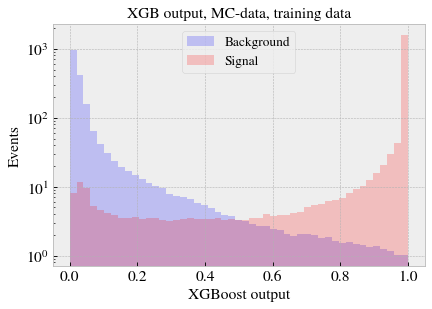

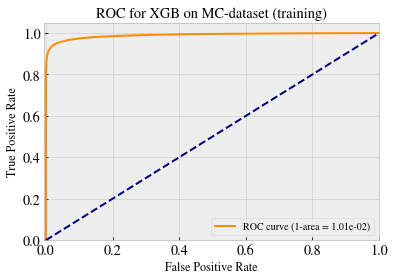

In [23]:
"""
TRAINING DATA
"""
y_pred = xgb.predict_proba( X_train ) 
y_b = y_pred[:,1][Y_train==0]
y_s = y_pred[:,1][Y_train==1]

name = "train.pdf"
title =  "XGB output, MC-data, training data"
plotHistoBS(y_b, y_s, wbkg, wsig, name, title,  nrBins = 50)

title = "ROC for XGB on MC-dataset (training)"

plotRoc(Y_train, y_pred, W_train, title)

267648


Save Image? [y/n] n


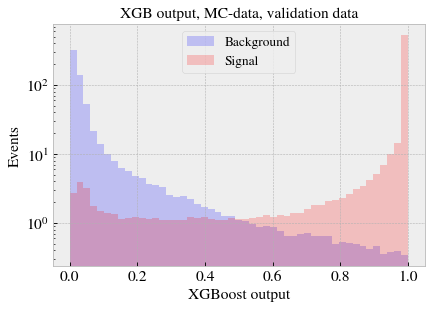

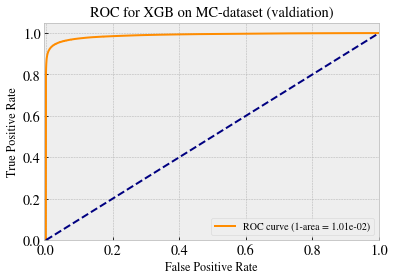

Best Threshold=0.490218, G-Mean=0.959


In [24]:
y_pred = xgb.predict_proba( X_val ) 
y_b = y_pred[:,1][Y_val==0]
y_s = y_pred[:,1][Y_val==1]

name = "val.pdf"
title =  "XGB output, MC-data, validation data"
plotHistoBS(y_b, y_s, wbkg_v, wsig_v, name, title, nrBins = 50)

title = "ROC for XGB on MC-dataset (valdiation)"
fpr, tpr, thresholds = plotRoc(Y_val, y_pred, W_val, title, return_score = True)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_threshold, gmeans[ix]))

Save Image? [y/n] n


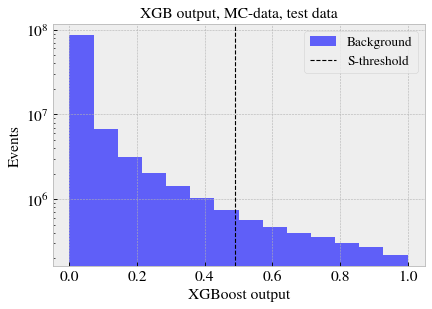

Nr of false positives 3004620


In [25]:
"""
TEST DATA
"""
y_b = xgb.predict_proba( X_test )[:,1]

name = "test.pdf"
title =  "XGB output, MC-data, test data"
plotHistoB(y_b, wbkg_t, name, title, best_threshold, nrBins = 15)
print(f"Nr of false positives {np.sum(y_b>best_threshold)}")

# Control Regions
In this section I will define the controll regions.

In [26]:
X_back = df[Y == 0.0]
CR_WW = X_back[(((X_back["isSF"] == 1)) & (abs(X_back["mll"]-91.2)<20) & (X_back["nbjet77"] == 0))]
CR_Top = X_back[(((X_back["isSF"] == 0))  & (X_back["nbjet77"] >= 1))]